# Building networks

**Don't forget compiling mod files.**

# 1. Cell objects

**Make sure that you reset the kernel at this point.** 

In Python, you can define custom data types that you can use to organize data and related operations. For example, so far we have worked with cell models in NEURON, which have common attributes and operations as:

1. Sections and segments,
2. Combining sections to define the morphology of a cell,
3. Active mechanisms and inserting them,
4. Synapses and connecting them to other cells, etc.


We can collect these into a cell object as follows:

In [1]:
from neuron import h, gui
from neuron import load_mechanisms

import numpy as np
import matplotlib.pyplot as plt


class Cell:
    """ Cell class"""
    
    # When a cell object is created this function is called first.
    # Note "self" in definition
    def __init__(self):
        
        self.synlist = []      # list of synapses in this cell

        # here are some operations to create a cell
        self.create_sections()
        self.build_topology()
        self.build_subsets()
        self.define_geometry()
        self.define_biophysics()
        self.create_synapses()

    # At this stage, we leave most of them unimplemented
    # This technique is called "the Template Method pattern" (https://sourcemaking.com/design_patterns/template_method)
    def create_sections(self):
        raise NotImplementedError("create_section() is not implemented.")

    def build_topology(self):
        raise NotImplementedError("build_topology() is not implemented.")
    
    def build_subsets(self):
        raise NotImplementedError("build_subsets() is not implemented.")

    def define_geometry(self):
        raise NotImplementedError("define_geometry() is not implemented.")

    def define_biophysics(self):
        raise NotImplementedError("define_biophysics() is not implemented.")

    def create_synapses(self):
        raise NotImplementedError("create_synapses() is not implemented.")
    
    # Here are something that will be commonly used by every cell
    # built based on this template
    
    def connect2target(self, target, thresh=0):
        """Make a new NetCon with this cell's membrane
        potential at the soma as the source (i.e. the spike detector)
        onto the target passed in (i.e. a synapse on a cell).
        Subclasses may override with other spike detectors."""
        nc = h.NetCon(self.soma(1)._ref_v, target, sec = self.soma)
        nc.threshold = thresh
        return nc

In [2]:
cell1 = Cell()

NotImplementedError: create_section() is not implemented.

In [3]:
class WB(Cell):
    
    def create_sections(self):
        """create a soma"""
        self.soma = h.Section(name="soma", cell=self)

    def build_topology(self):
        pass # single compartment
    
    def build_subsets(self):
        pass # single compartment
    
    def define_geometry(self):
        self.soma.L = 15
        self.soma.diam = 15

    def define_biophysics(self):
        h.v_init = -65
        self.soma.insert('wb')

    def create_synapses(self):
        self.synlist.append(h.Exp2Syn(self.soma(0.5))) # Excitatory
        self.synlist[-1].e = 0
        self.synlist[-1].tau1 = 0.1
        self.synlist[-1].tau2 = 2.0
        
        self.synlist.append(h.Exp2Syn(self.soma(0.5))) # Inhibitory     
        self.synlist[-1].e = -75
        
        # Here we use the same temporal parameters as excitatory synapses
        self.synlist[-1].tau1 = 0.1
        self.synlist[-1].tau2 = 2.0

In [4]:
cell1 = WB() # this should work

In [5]:
cell1.soma.psection()

{'point_processes': {'Exp2Syn': {Exp2Syn[0], Exp2Syn[1]}},
 'density_mechs': {'wb': {'gnabar': [0.035],
   'gkbar': [0.009],
   'gl': [0.0001],
   'el': [-65.0],
   'gna': [0.0],
   'gk': [0.0],
   'il': [0.0],
   'm': [0.0],
   'h': [0.0],
   'n': [0.0]}},
 'ions': {'na': {'ena': [50.0],
   'nai': [10.0],
   'nao': [140.0],
   'ina': [0.0],
   'dina_dv_': [0.0]},
  'k': {'ek': [-77.0],
   'ki': [54.4],
   'ko': [2.5],
   'ik': [0.0],
   'dik_dv_': [0.0]}},
 'morphology': {'L': 15.0,
  'diam': [15.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 35.4,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': '<__main__.WB object at 0x7f8f70fa7580>.soma',
 'hoc_internal_name': '__nrnsec_0x7f8f60530000',
 'cell': <__main__.WB at 0x7f8f70fa7580>}

In [7]:
cell1.synlist[1].e

-75.0

# 2. Network simulation

**Make sure that you reset the kernel at this point.** 

Here we will show how organize the network simulation code by using classes and objects. We prepared the `Cell` class in `cell_template.py` and define the `ConnorStevens` once again using the class.

In [1]:
from neuron import h, gui
from neuron import load_mechanisms

import numpy as np
import matplotlib.pyplot as plt

from cell_template import Cell

class WB(Cell):
    
    def create_sections(self):
        """create a soma"""
        self.soma = h.Section(name="soma", cell=self)

    def build_topology(self):
        pass # single compartment
    
    def build_subsets(self):
        pass # single compartment
    
    def define_geometry(self):
        self.soma.L = 15
        self.soma.diam = 15

    def define_biophysics(self):
        h.v_init = -65
        self.soma.insert('wb')

    def create_synapses(self):
        self.synlist.append(h.Exp2Syn(self.soma(0.5))) # Excitatory
        self.synlist[-1].e = 0
        self.synlist[-1].tau1 = 0.1
        self.synlist[-1].tau2 = 2.0
        
        self.synlist.append(h.Exp2Syn(self.soma(0.5))) # Inhibitory     
        self.synlist[-1].e = -75
        
        # Here we use the same temporal parameters as excitatory synapses
        self.synlist[-1].tau1 = 0.1
        self.synlist[-1].tau2 = 2.0

Now, we will build a network model based on this cell type. The network contains 1000 cells and 20% of the neurons are inhibitory while the rest is excitatory. Each cell randomly pulls inputs from 10% of the excitatory and inhibitory cell population.

In [2]:
Ncells = 500                    # Number of cells
Nexc = int((Ncells/5)*4)         # Excitatory cells = 80%
Ninh = int(Ncells/5)             # Inhibitory cells = 20%
nexcpre = int(Nexc*0.1)          # Presynaptic excitatory cells for each neuron = 10% of excitatory cells
ninhpre = int(Ninh*0.1)  # Presynaptic inhibitory cells for each neuron = 10% of inhibitory cells

print('Ncells =', Ncells, '\nNexc =', Nexc, '\nNinh =', Ninh, '\nnexcpre =',nexcpre, '\nninhpre =', ninhpre)

Ncells = 500 
Nexc = 400 
Ninh = 100 
nexcpre = 40 
ninhpre = 10


We use `SerialNetManager` from `net_manager` module, which will make building, running, and saving the data easier.

In [3]:
from net_manager import SerialNetManager

pnm = SerialNetManager(Ncells)

In [4]:
for i in range(Ncells):
    pnm.register_cell(i, WB())

Then, we connect an external stimulus to each neuron, which will *kickstart* the network activity.

In [5]:
ics = []
for i in range(Ncells):
    ic = h.NetStimFD(pnm.gid2cell[i].soma(0.5))
    ic.interval = 3 # 300 Hz
    ic.noise = 1
    ic.start = 0
    ic.duration = 7
    ic.seed(i+1223)
    
    nc = h.NetCon(ic, pnm.gid2cell[i].synlist[0])
    nc.weight[0] = 5e-3 # 5 nS
    ics.append((ic, nc))


Then we let the network manager know that we will record spikes from all the cells.

In [6]:
pnm.want_all_spikes()

We haven't wired the cells yet, but the neurons will fire with external stimuli. Let's try a short simulation!

In [9]:
h.tstop = 100
h.init()
pnm.run()

[Text(0.5, 0, 'Time (ms)'), Text(0, 0.5, 'Neuron'), (0.0, 100.0)]

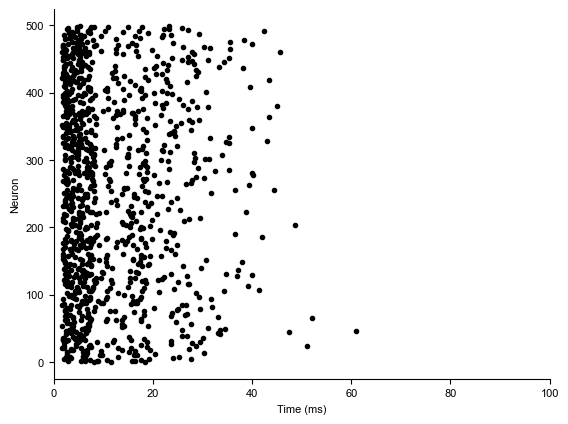

In [11]:
fig, ax = plt.subplots()
ax.plot(pnm.spikevec, pnm.idvec, '.k')
ax.set(xlabel='Time (ms)', ylabel='Neuron', xlim=[0, 100])

Now we wire the cells:

In [12]:
gexc = 3e-3     # g_exc = 3 nS
ginh = 5.*gexc   # g_inh/g_exc = 5

# Reset all NetCon's
pnm.nc_reset()

# Go around every cell
for i in range(Ncells):
    
    # Choose nexcpre cells from Nexc excitatory cells
    exc_pre = np.random.randint(0, Nexc, nexcpre)
    # Choose ninhpre cells from Ninh inhibitory cells
    inh_pre = np.random.randint(Nexc, Ncells, ninhpre)

    for k in exc_pre:
        if i!=k:  # No self-connection
            # pnm.nc_append(id_of_presyn_cell, id_of_postsyn_cell, synapse_id, syn_weight, propagation_delay, threshold)
            pnm.nc_append(k, i, 0, gexc, 0.1, thresh=-10)

    for k in inh_pre:
        if i!=k:  # No self-connection
            pnm.nc_append(k, i, 1, ginh, 0.1, thresh=-10)

In [15]:
#This part is for changing the synaptic conductance!

gexc_o = gexc
ginh_o = ginh

gexc = 3e-3     # g_exc = 3 nS
ginh = 2.*gexc   # g_inh/g_exc = 5


for k in pnm.netcons:
    if pnm.netcons[k].weight[0]==gexc_o:
        pnm.netcons[k].weight[0] = gexc
    if pnm.netcons[k].weight[0]==ginh_o:
        pnm.netcons[k].weight[0] = ginh
        
# for k in pnm.netcons:
#     print(pnm.netcons[k].e)

Let's run it!

In [16]:
h.tstop = 250
h.init()
pnm.run()

[Text(0.5, 0, 'Time (ms)'), Text(0, 0.5, 'Neuron')]

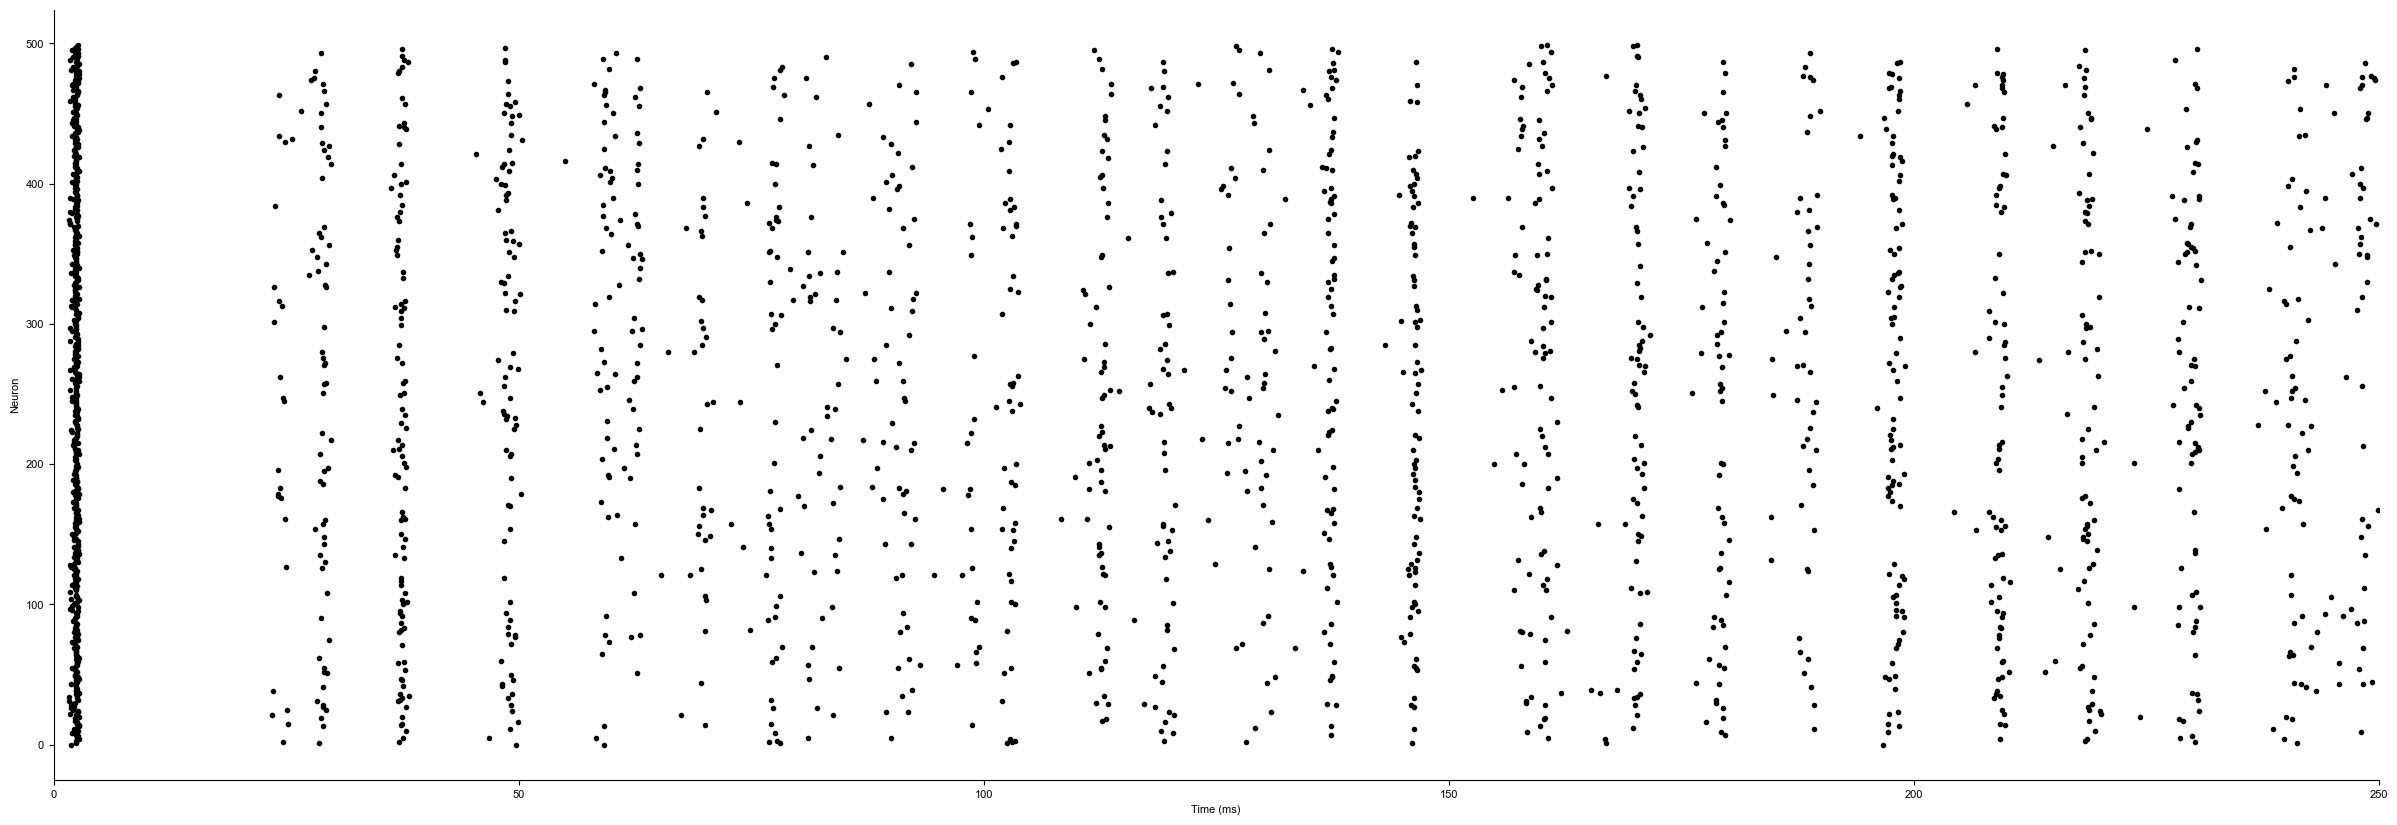

In [17]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.plot(pnm.spikevec, pnm.idvec, '.k')
ax.set(xlim=[0, h.tstop])
ax.set(xlabel='Time (ms)', ylabel='Neuron')

## Analyzing data

In most cases, we convert spike time data into spike train histograms with time bins.

In [41]:
x = np.array([pnm.spikevec, pnm.idvec]).T
x

array([[  1.875,   0.   ],
       [ 49.7  ,   0.   ],
       [ 59.15 ,   0.   ],
       ...,
       [  2.6  , 499.   ],
       [160.6  , 499.   ],
       [170.275, 499.   ]])

[(0.0, 250.0), (0.0, 67.0), Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'spikes')]

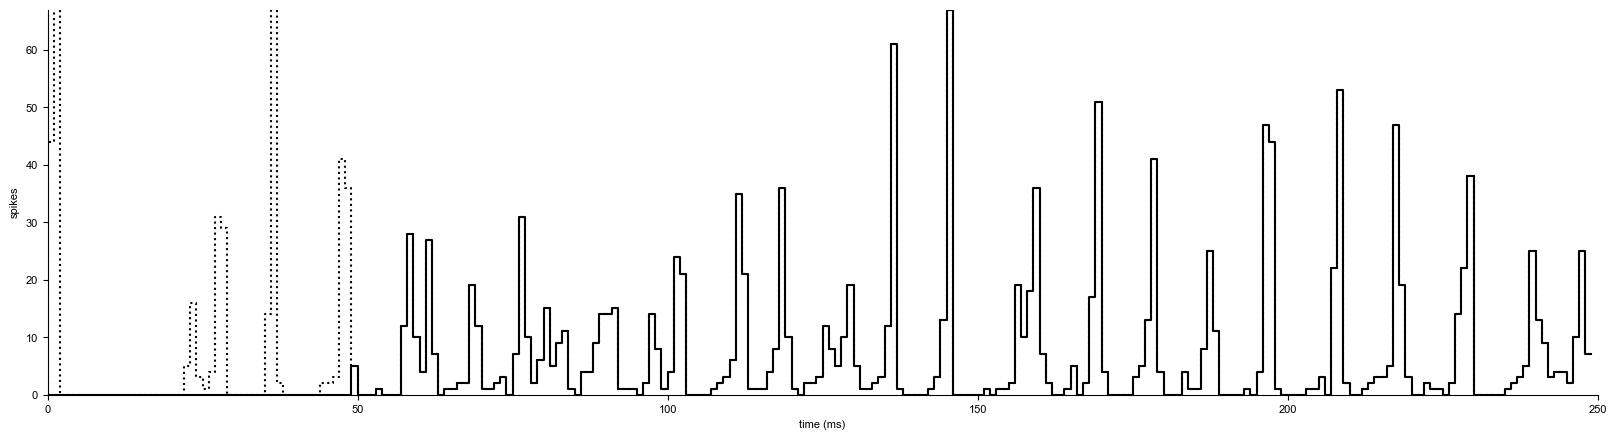

In [42]:
tstop = 250
tc = np.arange(tstop+1)
spikecount_all, _ = np.histogram(x[:,0], tc)
t = tc[:-1]

_, ax = plt.subplots(figsize=(20, 5))
ax.step(t, spikecount_all, ':k')
x = x[x[:,0]>50, :]
spikecount_all, _ = np.histogram(x[:,0], tc)
ax.step(t, spikecount_all, 'k')
ax.set(xlim=[0, tstop], ylim=[0, spikecount_all.max()], xlabel='time (ms)', ylabel='spikes')

Making spike trains for individual neurons is also straightforward.

[(0.0, 250.0), Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'neuron')]

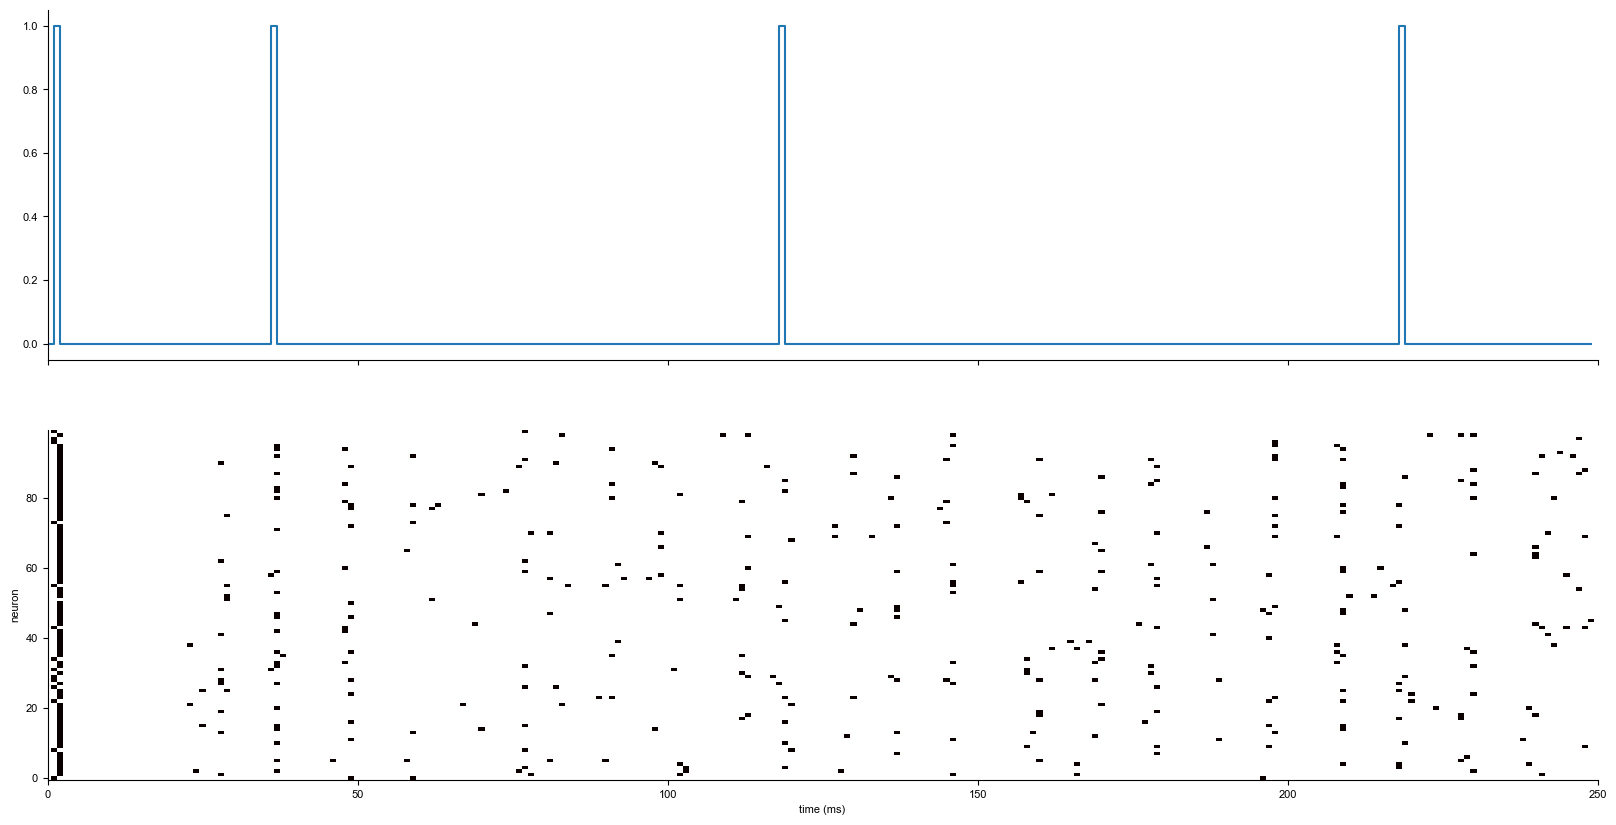

In [25]:
spiketrain = np.zeros((spikecount_all.size, Ncells))

for i in range(Ncells):
    iselect = (x[:, 1] == i)
    spiketrain[:, i], _ = np.histogram(x[iselect, 0], tc)
    
_, ax = plt.subplots(nrows=2, figsize=(20, 10), sharex=True)

ax[0].step(t, spiketrain[:,10])
ax[0].set(xlim=[0, tstop])

ax[1].pcolormesh(t, np.arange(100), spiketrain[:,:100].T, cmap='hot_r')
ax[1].set(xlim=[0, tstop],
       xlabel='time (ms)',
       ylabel='neuron')

Noticing transient oscillations in our data, we can try analysis in a frequency domain.

[Text(0.5, 1.0, 'Spectrogram'),
 Text(0, 0.5, 'frequency (Hz)'),
 Text(0.5, 0, 'time (ms)'),
 (0.0, 250.0),
 (0.0, 250.0)]

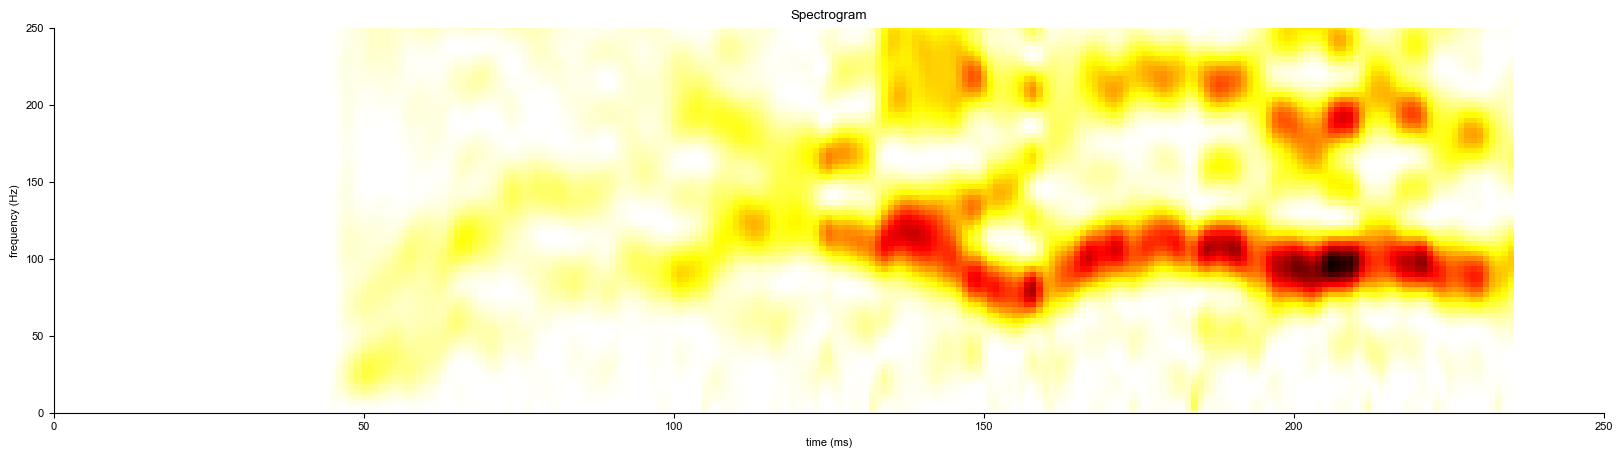

In [31]:
import scipy.signal

freqs, tz, spectrogram = scipy.signal.spectrogram(
    spikecount_all*1000,
    fs=1000,
    window=('tukey',0.25),
    nperseg=30,
    noverlap=29,
    nfft=300
)

_, ax = plt.subplots(figsize=(20, 5))
ax.pcolormesh(tz*1000, freqs, spectrogram,
               cmap='hot_r')
ax.set(title='Spectrogram',
    ylabel='frequency (Hz)',
    xlabel='time (ms)',
    ylim=[0, 250],
    xlim=[0, tstop])